<a href="https://colab.research.google.com/github/AustinAlgebra/volcanoes_on_venus/blob/main/final_volcanoes_on_venus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Volcanos On Venus



In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from google.colab import files


In [2]:
uploaded = files.upload()

# You need to download your API key from Kaggle to your computer.
# Go to Kaggle and click into your profile to find your API key.
# When prompted, upload that file, which is just a JSON dictionary.

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d fmena14/volcanoesvenus

 94% 217M/231M [00:16<00:01, 12.3MB/s]
100% 231M/231M [00:16<00:00, 14.7MB/s]


In [4]:
!unzip volcanoesvenus.zip

Archive:  volcanoesvenus.zip
  inflating: Volcanoes_test/test_images.csv  
  inflating: Volcanoes_test/test_labels.csv  
  inflating: Volcanoes_train/train_images.csv  
  inflating: Volcanoes_train/train_labels.csv  
  inflating: volcanoes_test/test_images.csv  
  inflating: volcanoes_test/test_labels.csv  
  inflating: volcanoes_train/train_images.csv  
  inflating: volcanoes_train/train_labels.csv  


In [5]:
# It appears the data is already separated into test and train CSV's.
# Turning those into DataFrames using Pandas.

test_img_df = pd.read_csv('Volcanoes_test/test_images.csv')
test_label_df = pd.read_csv('Volcanoes_test/test_labels.csv')
train_img_df = pd.read_csv('Volcanoes_train/train_images.csv')
train_label_df = pd.read_csv('Volcanoes_train/train_labels.csv')

In [6]:
# Let's take a look at how the data is distributed between these different files.
# You can see that the image dataframes have 12100 rows for 100px by 100px images.
# Each row is an image.

# You will see there is a problem with the number of rows.
# The label dataframes both have one more row than the image dataframes.

print(f'train img: {train_img_df.shape}')
print(f'train label: {train_label_df.shape}')
print(f'test img: {test_img_df.shape}')
print(f'test label: {test_label_df.shape}')

train img: (6999, 12100)
train label: (7000, 4)
test img: (2733, 12100)
test label: (2734, 4)


In [7]:
# Let's see what is going on with these image files.

train_img_df.head()

,95,101,99,103,95.1,86,96,89,70,104,115,96.1,89.1,102,109,108,102.1,104.1,95.2,91,100,99.1,97,100.1,107,109.1,98,98.1,94,98.2,102.2,87,82,94.1,105,93,102.3,107.1,98.3,105.1,...,101.417,95.420,105.363,103.377,74.49,88.287,106.348,111.212,90.324,96.422,101.418,90.325,97.425,102.435,97.426,106.349,108.284,107.327,93.359,74.50,106.350,115.129,107.328,102.436,91.347,103.378,111.213,105.364,116.102,117.111,111.214,107.329,92.354,89.258,103.379,99.414,117.112,116.103,118.82,96.423
0,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,95,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81
1,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,86,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,101,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96
3,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,105,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115
4,79,95,90,82,73,74,77,75,82,87,84,81,83,69,72,84,93,84,89,83,86,89,95,94,82,80,96,96,89,86,93,88,82,70,76,84,82,59,81,101,...,94,78,73,91,94,90,81,80,70,71,73,84,87,89,97,99,92,77,87,96,75,78,92,72,83,86,95,87,78,90,90,80,79,78,65,71,62,97,89,73


In [8]:
# If you look at the column names, you can see that they are actually
# the values of the 'missing image'. We need to turn those into the first row.
# Here I create a function that turns that picture into the first column,
# then rename the columns to be integers from 0 to 12099.

def ImageDFFix(df):
    # Adding column names as row -1
    df.loc[-1] = df.columns.values.astype(float).astype(int)  
    # Shift the index by 1
    df.index = df.index + 1
    # Sort the index
    df.sort_index(inplace=True)
    # Give the columns new names, integers 0 through 12099
    df.columns = np.arange(len(df.columns))

# Creating copy DataFrames and applying the Fix code to it
train_img_fix = train_img_df.copy()
ImageDFFix(train_img_fix)

test_img_fix = test_img_df.copy()
ImageDFFix(test_img_fix)

train_img_fix.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,101,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,95,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,86,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,101,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,105,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115


In [9]:
# The image DataFrames are looking pretty good now.
# Let's take a look at the label DataFrames.

print(train_label_df.info())
train_label_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Volcano?          7000 non-null   int64  
 1   Type              1000 non-null   float64
 2   Radius            1000 non-null   float64
 3   Number Volcanoes  1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 218.9 KB
None


,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


From the Data Literature on Kaggle:
* Volcano?: if in the image there are volcanoes (Main target), 1 or 0. 
  * for Volcano?=0 this three next features are NaN

* Type: 1= definitely a volcano,2 =probably, 3= possibly, 4= only a pit is visible
* Radius: is the radius of the volcan in the center of the image, in pixels
* Number Volcanoes: The number of volcanoes in the image

In [10]:
# For the sake of this project, I will be focusing on Volcanos? as a target variable
# I want to combine the data and then create my own test dataframe
# using 'train test split' and the 'stratify' setting.

# Here I combine the image data with the target column from the label dataframe
# for both the training and test data.

X_train = train_img_fix
y_train = train_label_df['Volcano?']
train_data_df = pd.concat([X_train, y_train], axis=1)

X_test = test_img_fix
y_test = test_label_df['Volcano?']
test_data_df = pd.concat([X_test, y_test], axis=1)

# Now I combine the training and test dataframes for re-splitting later.

df = pd.concat([train_data_df, test_data_df], axis=0)

print(df.head())
print(train_data_df.shape)
print(test_data_df.shape)
print(df.shape)

     0    1    2    3   4    5  ...  12095  12096  12097  12098  12099  Volcano?
0   95  101   99  103  95   86  ...     99    117    116    118     96         1
1   91   92   91   89  92   93  ...    105    104    100     90     81         0
2   87   70   72   74  84   78  ...     80     91     80     84     90         0
3    0    0    0    0   0    0  ...     90     92     80     88     96         0
4  114  118  124  119  95  118  ...    104    106    117    111    115         0

[5 rows x 12101 columns]
(7000, 12101)
(2734, 12101)
(9734, 12101)


Contains Volcano


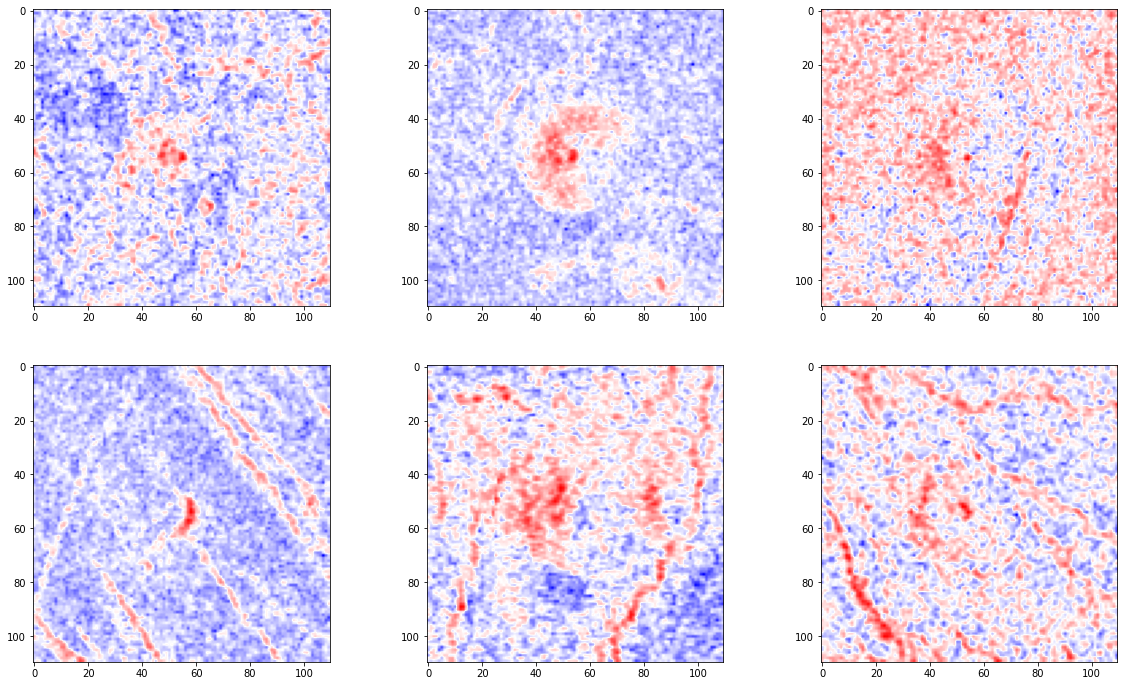

No Volcano


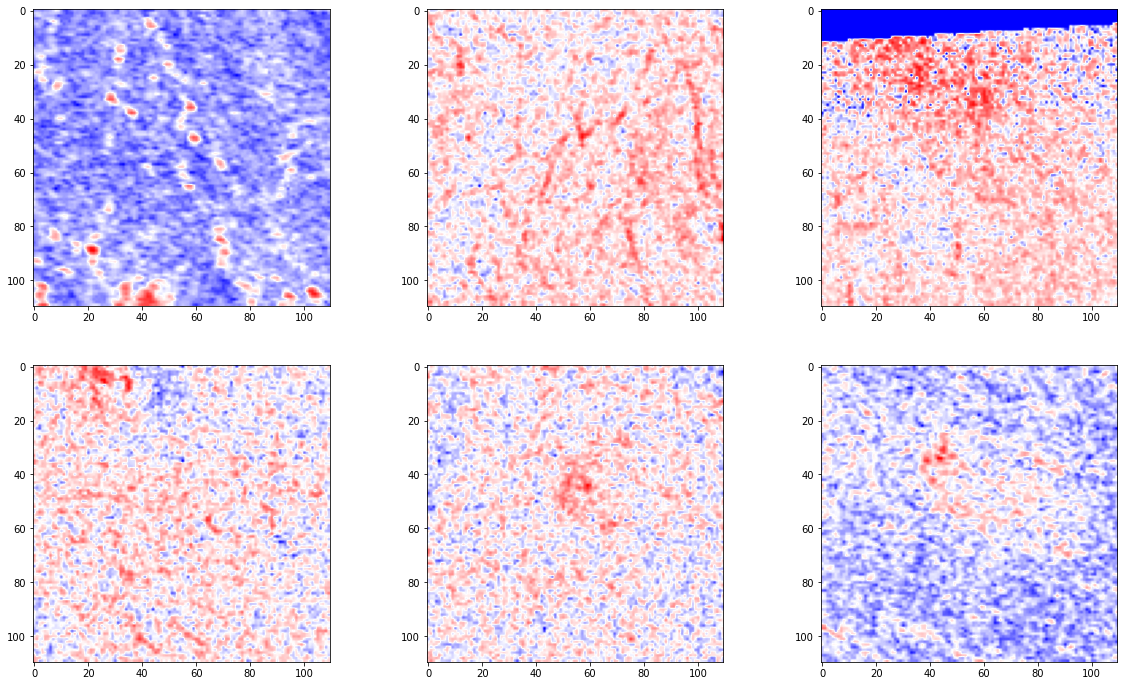

In [11]:
# Let's see what these pictures look like

volcano_df = df[(df['Volcano?']==1)]
no_df = df[(df['Volcano?']==0)]

print('Contains Volcano')
plt.figure(figsize=[20,12])
for x in range(6):
    row = np.array(volcano_df.iloc[x,:-1])
    image = row.reshape((110,110))
    plt.subplot(2,3,x+1)
    plt.imshow(image,cmap="bwr")
plt.show()

print('No Volcano')
plt.figure(figsize=[20,12])
for x in range(6):
    row = np.array(no_df.iloc[x,:-1])
    image = row.reshape((110,110))
    plt.subplot(2,3,x+1)
    plt.imshow(image,cmap="bwr")

plt.show()

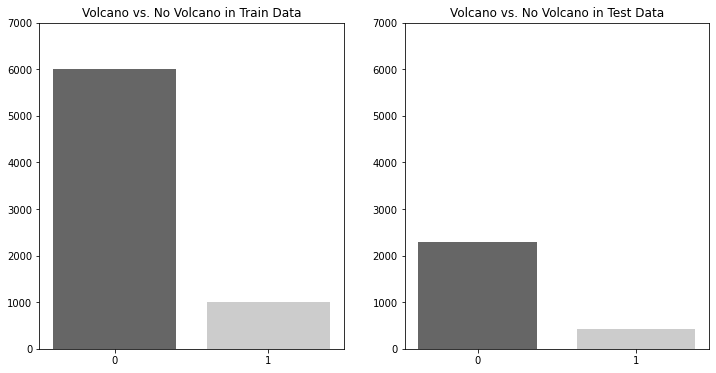

The percent labeled Volcano = 14.2857%
Percent of data in test set: 28.0871%


In [12]:
# Now let's see how the data is balanced between classes of Volcano and No Volcano. 
# In the description in Kaggle it said there was an imbalance. 
# Let's see how bad it is.

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.bar(train_data_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         train_data_df.groupby('Volcano?')['Volcano?'].count(),
         color=['.4','.8'])
plt.ylim(0,7000)
plt.title('Volcano vs. No Volcano in Train Data')

plt.subplot(1,2,2)
plt.bar(test_data_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         test_data_df.groupby('Volcano?')['Volcano?'].count(),
        width=.75,
         color=['.4','.8'])
plt.ylim(0,7000)
plt.title('Volcano vs. No Volcano in Test Data')

plt.show()

# Let's also check the percent labeled Volcano in the training data by the numbers

percent_volcano = (train_data_df['Volcano?'].value_counts()[1]/train_data_df.shape[0])*100
print(f'The percent labeled Volcano = {round(percent_volcano, 4)}%')

# What percent of the total data is in the test set?

percent_test = test_data_df.shape[0]/df.shape[0]
print(f'Percent of data in test set: {round(percent_test*100,4)}%')

In [13]:
# This bar graph shows that there are way more images with No Volcano than images with Volcano.
# This is a problem that will need to be addressed.

# I want to resample my training and test data so that test set is 20%
# Need to use 'stratify' and 'shuffle' to get the same proportion of
# Volcano to No Volcano in the training and test dataframes.

# Feature dataframe:
X = df.iloc[:,:-1]

# Target dataframe:
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    shuffle=True)

In [14]:
# Let's check that this created the desired ratio of test data.

print(f'X train: {X_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y train: {y_train.shape[0]}')
print(f'y test: {y_test.shape[0]}')
percent_test = X_test.shape[0]/df.shape[0]
print(f'Percent of data in test set: {round(percent_test*100,4)}%')

X train: (7787, 12100)
X test: (1947, 12100)
y train: 7787
y test: 1947
Percent of data in test set: 20.0021%


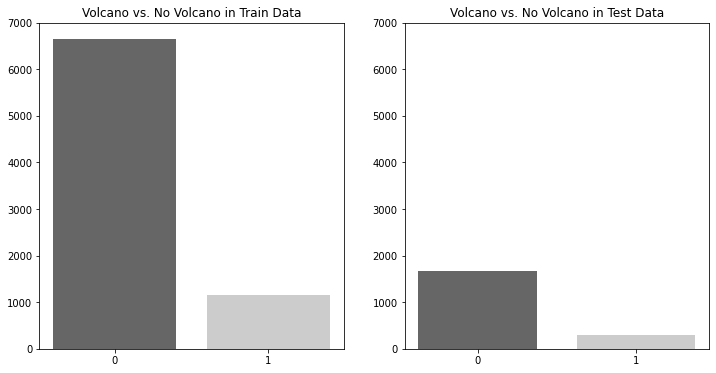

The percent labeled Volcano = 14.73%
Percent of data in test set: 20.0021%


In [15]:
# I want to visualize that 'stratify' worked and kept a similar ratio of No Volcano to Volcano

train_data_df = pd.concat([X_train, y_train], axis=1)
test_data_df = pd.concat([X_test, y_test], axis=1)


plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.bar(train_data_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         train_data_df.groupby('Volcano?')['Volcano?'].count(),
         color=['.4','.8'])
plt.ylim(0,7000)
plt.title('Volcano vs. No Volcano in Train Data')

plt.subplot(1,2,2)
plt.bar(test_data_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         test_data_df.groupby('Volcano?')['Volcano?'].count(),
        width=.75,
         color=['.4','.8'])
plt.ylim(0,7000)
plt.title('Volcano vs. No Volcano in Test Data')

plt.show()

y_train_df = pd.DataFrame(y_train)

# Check the percent in Volcano class:

percent_volcano = (y_train.value_counts()[1]/y_train.shape[0])*100
print(f'The percent labeled Volcano = {round(percent_volcano, 2)}%')

# Check the percent in Training Data:

print(f'Percent of data in test set: {round(percent_test*100,4)}%')

Random under-sampling:
1    1147
0    1147
Name: Volcano?, dtype: int64


Text(0.5, 1.0, 'Volcano vs. No Volcano after Random Undersampling')

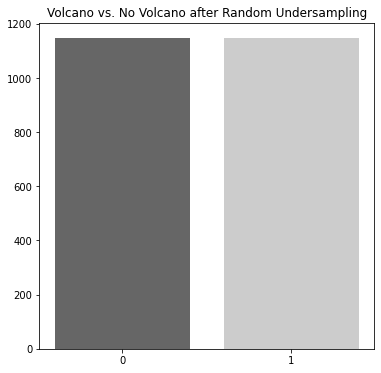

In [16]:
# It looks very similar. You can see that the percent is the same as well.
# This will be an issue when it comes time to run models.
# I want to try a two different methods for sampling.
# I will try random undersampling and I will try SMOTE oversampling techniques.
# I will only apply sampling to my train data.

# First, random undersampling:

# Class count
target_0_count, target_1_count=train_data_df.iloc[:,-1].value_counts()
# Seperate classes
target_0 = train_data_df[train_data_df.iloc[:,-1] == 0]
target_1 = train_data_df[train_data_df.iloc[:,-1] == 1]
# Resample target1 to match target 0 count
target_0_undersample = target_0.sample(target_1_count)
# Merge back to single df
undersample_df = pd.concat([target_0_undersample, target_1], 
                             axis=0)
# Show counts and plot
print('Random under-sampling:')
print(undersample_df.iloc[:,-1].value_counts())

plt.figure(figsize=(6,6))
plt.bar(undersample_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         undersample_df.groupby('Volcano?')['Volcano?'].count(),
         color=['.4','.8'])
plt.title('Volcano vs. No Volcano after Random Undersampling')

In [17]:
# A major setback to random undersampling is that we just lost thousands of images.
# Losing data does not seem like an ideal option, but we will compare it.

# Creating X and y from my undersampled data to use in models later.
# Adding suffix _us for undersample

X_train_us = undersample_df.iloc[:,:-1]
y_train_us = undersample_df.iloc[:,-1]

print(f'X train undersampled: {X_train_us.shape}')
print(f'y train undersampled: {y_train_us.shape[0]}')

X train undersampled: (2294, 12100)
y train undersampled: 2294


In [18]:
# Now trying SMOTE which is a smart oversampling technique.

sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [19]:
# The SMOTE process turned the X_train_sm into an array.
# Turning it back into a DataFrame:

X_train_sm = pd.DataFrame(X_train_sm)
y_train_sm_df = pd.DataFrame(y_train_sm)
y_train_sm_df.rename(columns={0: 'Volcano?'}, inplace=True)

# Let's check that this turned out the way I was hoping.
print(X_train_sm.head())
print(y_train_sm_df.head())

# Check that these numbers match up and see how many rows we have.
print(f'X train oversampled: {X_train_sm.shape}')
print(f'y train oversampled: {y_train_sm.shape[0]}')

   0      1      2      3      4      ...  12095  12096  12097  12098  12099
0     69     88     92     90     80  ...     82     95     86     89     97
1    104    108    100    103    107  ...    105    112     99     80    106
2    112    107    117    117    111  ...    109    111    107     94     87
3     99     94     77     82     84  ...     88     89     90     76     80
4     93    104    108    129    157  ...     88    102    101     91     72

[5 rows x 12100 columns]
   Volcano?
0         0
1         0
2         1
3         0
4         0
X train oversampled: (13280, 12100)
y train oversampled: 13280


Text(0.5, 1.0, 'Volcano vs. No Volcano after SMOTE Oversampling')

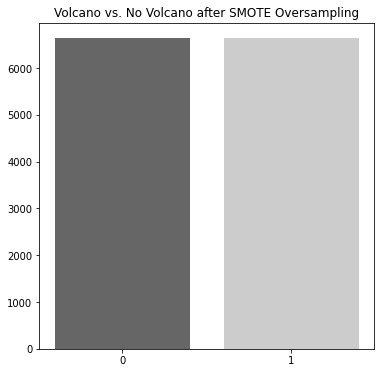

In [20]:
smote_df = pd.concat([X_train_sm, y_train_sm_df], axis=1)

plt.figure(figsize=(6,6))
plt.bar(smote_df.groupby('Volcano?')['Volcano?'].count().index.astype(str),
         smote_df.groupby('Volcano?')['Volcano?'].count(),
         color=['.4','.8'])
plt.title('Volcano vs. No Volcano after SMOTE Oversampling')

# Models
## Part 1: Comparing different Sampling Techniques between Logistic Regression Classifier and Random Forest Classifier

In [25]:
# Okay now I have my original data, my random undersampled data, and my SMOTE oversampled data.
# Let's see how they compare in some models out of the box.
# Starting with Logistic Regression and my original data.

scoring = ['accuracy','precision','recall','f1']

lrc = LogisticRegression()
#cross_validate(lrc, X_train, y_train, scoring=scoring, cv=3)

In [26]:
# Compare that to Random Forest, a non-linear model.

rfc = RandomForestClassifier()
#cross_validate(rfc, X_train, y_train, scoring=scoring, cv=3)

In [27]:
# I got an error saying that I should look into preprocessing which includes scaling data.
# Since all of the data are images with pixels values 0 to 255, I could just divide
# all of the cells by 255 to get the values between 0 and 1.

X_train_scale = X_train.iloc[:,:] / 255
X_train_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
1019,0.270588,0.345098,0.360784,0.352941,0.313725,0.325490,0.423529,0.392157,0.290196,0.321569,0.372549,0.384314,0.411765,0.349020,0.368627,0.341176,0.372549,0.443137,0.450980,0.486275,0.462745,0.317647,0.274510,0.380392,0.352941,0.341176,0.376471,0.419608,0.419608,0.376471,0.341176,0.356863,0.364706,0.415686,0.400000,0.372549,0.298039,0.298039,0.329412,0.352941,...,0.396078,0.341176,0.325490,0.384314,0.419608,0.352941,0.317647,0.380392,0.372549,0.392157,0.384314,0.388235,0.317647,0.360784,0.403922,0.317647,0.376471,0.392157,0.384314,0.329412,0.368627,0.419608,0.435294,0.431373,0.435294,0.454902,0.396078,0.443137,0.423529,0.341176,0.349020,0.329412,0.360784,0.321569,0.301961,0.321569,0.372549,0.337255,0.349020,0.380392
2165,0.407843,0.423529,0.392157,0.403922,0.419608,0.396078,0.356863,0.333333,0.388235,0.450980,0.462745,0.478431,0.423529,0.298039,0.388235,0.392157,0.341176,0.384314,0.376471,0.345098,0.352941,0.329412,0.380392,0.415686,0.380392,0.376471,0.349020,0.337255,0.298039,0.360784,0.321569,0.352941,0.407843,0.427451,0.368627,0.372549,0.407843,0.376471,0.388235,0.380392,...,0.490196,0.486275,0.396078,0.419608,0.384314,0.376471,0.388235,0.368627,0.388235,0.380392,0.384314,0.384314,0.329412,0.392157,0.403922,0.341176,0.392157,0.372549,0.380392,0.415686,0.435294,0.423529,0.403922,0.372549,0.317647,0.364706,0.403922,0.376471,0.364706,0.368627,0.396078,0.427451,0.396078,0.372549,0.372549,0.411765,0.439216,0.388235,0.313725,0.415686
6408,0.439216,0.419608,0.458824,0.458824,0.435294,0.419608,0.427451,0.411765,0.403922,0.431373,0.478431,0.521569,0.498039,0.423529,0.341176,0.376471,0.431373,0.443137,0.392157,0.384314,0.419608,0.411765,0.396078,0.415686,0.427451,0.407843,0.392157,0.431373,0.466667,0.458824,0.392157,0.368627,0.403922,0.419608,0.423529,0.427451,0.427451,0.423529,0.396078,0.372549,...,0.364706,0.349020,0.349020,0.368627,0.376471,0.407843,0.392157,0.411765,0.380392,0.372549,0.380392,0.423529,0.419608,0.376471,0.403922,0.443137,0.454902,0.427451,0.392157,0.403922,0.380392,0.349020,0.380392,0.372549,0.368627,0.345098,0.364706,0.403922,0.415686,0.439216,0.450980,0.439216,0.447059,0.462745,0.447059,0.427451,0.435294,0.419608,0.368627,0.341176
1204,0.388235,0.368627,0.301961,0.321569,0.329412,0.305882,0.309804,0.376471,0.388235,0.376471,0.317647,0.364706,0.364706,0.396078,0.282353,0.341176,0.325490,0.290196,0.341176,0.329412,0.356863,0.317647,0.270588,0.356863,0.396078,0.388235,0.368627,0.431373,0.447059,0.341176,0.317647,0.345098,0.341176,0.294118,0.274510,0.376471,0.411765,0.419608,0.349020,0.309804,...,0.274510,0.329412,0.345098,0.376471,0.415686,0.415686,0.384314,0.345098,0.349020,0.282353,0.305882,0.313725,0.356863,0.368627,0.349020,0.356863,0.305882,0.243137,0.337255,0.329412,0.317647,0.262745,0.282353,0.352941,0.364706,0.356863,0.380392,0.423529,0.419608,0.478431,0.564706,0.509804,0.400000,0.380392,0.305882,0.345098,0.349020,0.352941,0.298039,0.313725
2344,0.364706,0.407843,0.423529,0.505882,0.615686,0.576471,0.423529,0.298039,0.352941,0.415686,0.403922,0.313725,0.325490,0.376471,0.368627,0.317647,0.290196,0.372549,0.368627,0.360784,0.349020,0.254902,0.368627,0.380392,0.384314,0.372549,0.321569,0.321569,0.372549,0.349020,0.321569,0.352941,0.400000,0.380392,0.341176,0.341176,0.337255,0.396078,0.341176,0.266667,...,0.431373,0.443137,0.427451,0.439216,0.345098,0.356863,0.400000,0.349020,0.380392,0.396078,0.396078,0.364706,0.372549,0.396078,0.419608,0.321569,0.298039,0.364706,0.388235,0.352941,0.329412,0.396078,0.423529,0.427451,0.376471,0.356863,0.349020,0.415686,0.462745,0.443137,0.396078,0.400000,0.392157,0.364706,0.368627,0.345098,0.400000,0.396078,0.356863,0.282353


In [28]:
# Successfully scaled to [0,1] interval.
# Let's see how that goes.

#cross_validate(lrc, X_train_scale, y_train, scoring=scoring, cv=3)

In [29]:
# Increasing max iterations to achieve convergance.

lrc = LogisticRegression(max_iter=1000)
#cross_validate(lrc, X_train_scale, y_train, scoring=scoring, cv=3)

In [30]:
# Compare that to Random Forest, a non-linear model.

rfc = RandomForestClassifier()
#cross_validate(rfc, X_train_scale, y_train, scoring=scoring, cv=3)

In [31]:
# Wow. Logistic Regression is better.
# Let's see how they compare with the other sampling techniques.
# Starting with random undersampling.

X_train_us_scale = X_train_us.iloc[:,:] / 255

#cross_validate(lrc, X_train_us_scale, y_train_us, scoring=scoring, cv=3)

In [32]:
# That's better for the non-accuracy scores.
# Comparing to Random Forest Classifier.

#cross_validate(rfc, X_train_us_scale, y_train_us, scoring=scoring, cv=3)

In [33]:
# Okay logistic regression is better for undersampling, too.
# Let's try with the SMOTE oversampling data.

X_train_sm_scale = X_train_sm.iloc[:,:] / 255
X_train_sm_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,0.270588,0.345098,0.360784,0.352941,0.313725,0.325490,0.423529,0.392157,0.290196,0.321569,0.372549,0.384314,0.411765,0.349020,0.368627,0.341176,0.372549,0.443137,0.450980,0.486275,0.462745,0.317647,0.274510,0.380392,0.352941,0.341176,0.376471,0.419608,0.419608,0.376471,0.341176,0.356863,0.364706,0.415686,0.400000,0.372549,0.298039,0.298039,0.329412,0.352941,...,0.396078,0.341176,0.325490,0.384314,0.419608,0.352941,0.317647,0.380392,0.372549,0.392157,0.384314,0.388235,0.317647,0.360784,0.403922,0.317647,0.376471,0.392157,0.384314,0.329412,0.368627,0.419608,0.435294,0.431373,0.435294,0.454902,0.396078,0.443137,0.423529,0.341176,0.349020,0.329412,0.360784,0.321569,0.301961,0.321569,0.372549,0.337255,0.349020,0.380392
1,0.407843,0.423529,0.392157,0.403922,0.419608,0.396078,0.356863,0.333333,0.388235,0.450980,0.462745,0.478431,0.423529,0.298039,0.388235,0.392157,0.341176,0.384314,0.376471,0.345098,0.352941,0.329412,0.380392,0.415686,0.380392,0.376471,0.349020,0.337255,0.298039,0.360784,0.321569,0.352941,0.407843,0.427451,0.368627,0.372549,0.407843,0.376471,0.388235,0.380392,...,0.490196,0.486275,0.396078,0.419608,0.384314,0.376471,0.388235,0.368627,0.388235,0.380392,0.384314,0.384314,0.329412,0.392157,0.403922,0.341176,0.392157,0.372549,0.380392,0.415686,0.435294,0.423529,0.403922,0.372549,0.317647,0.364706,0.403922,0.376471,0.364706,0.368627,0.396078,0.427451,0.396078,0.372549,0.372549,0.411765,0.439216,0.388235,0.313725,0.415686
2,0.439216,0.419608,0.458824,0.458824,0.435294,0.419608,0.427451,0.411765,0.403922,0.431373,0.478431,0.521569,0.498039,0.423529,0.341176,0.376471,0.431373,0.443137,0.392157,0.384314,0.419608,0.411765,0.396078,0.415686,0.427451,0.407843,0.392157,0.431373,0.466667,0.458824,0.392157,0.368627,0.403922,0.419608,0.423529,0.427451,0.427451,0.423529,0.396078,0.372549,...,0.364706,0.349020,0.349020,0.368627,0.376471,0.407843,0.392157,0.411765,0.380392,0.372549,0.380392,0.423529,0.419608,0.376471,0.403922,0.443137,0.454902,0.427451,0.392157,0.403922,0.380392,0.349020,0.380392,0.372549,0.368627,0.345098,0.364706,0.403922,0.415686,0.439216,0.450980,0.439216,0.447059,0.462745,0.447059,0.427451,0.435294,0.419608,0.368627,0.341176
3,0.388235,0.368627,0.301961,0.321569,0.329412,0.305882,0.309804,0.376471,0.388235,0.376471,0.317647,0.364706,0.364706,0.396078,0.282353,0.341176,0.325490,0.290196,0.341176,0.329412,0.356863,0.317647,0.270588,0.356863,0.396078,0.388235,0.368627,0.431373,0.447059,0.341176,0.317647,0.345098,0.341176,0.294118,0.274510,0.376471,0.411765,0.419608,0.349020,0.309804,...,0.274510,0.329412,0.345098,0.376471,0.415686,0.415686,0.384314,0.345098,0.349020,0.282353,0.305882,0.313725,0.356863,0.368627,0.349020,0.356863,0.305882,0.243137,0.337255,0.329412,0.317647,0.262745,0.282353,0.352941,0.364706,0.356863,0.380392,0.423529,0.419608,0.478431,0.564706,0.509804,0.400000,0.380392,0.305882,0.345098,0.349020,0.352941,0.298039,0.313725
4,0.364706,0.407843,0.423529,0.505882,0.615686,0.576471,0.423529,0.298039,0.352941,0.415686,0.403922,0.313725,0.325490,0.376471,0.368627,0.317647,0.290196,0.372549,0.368627,0.360784,0.349020,0.254902,0.368627,0.380392,0.384314,0.372549,0.321569,0.321569,0.372549,0.349020,0.321569,0.352941,0.400000,0.380392,0.341176,0.341176,0.337255,0.396078,0.341176,0.266667,...,0.431373,0.443137,0.427451,0.439216,0.345098,0.356863,0.400000,0.349020,0.380392,0.396078,0.396078,0.364706,0.372549,0.396078,0.419608,0.321569,0.298039,0.364706,0.388235,0.352941,0.329412,0.396078,0.423529,0.427451,0.376471,0.356863,0.349020,0.415686,0.462745,0.443137,0.396078,0.400000,0.392157,0.364706,0.368627,0.345098,0.400000,0.396078,0.356863,0.282353


In [34]:
#cross_validate(lrc, X_train_sm_scale, y_train_sm, scoring=scoring, cv=3)

{'fit_time': array([ 9.84223986,  9.61964107, 10.42056465]),

 'score_time': array([0.08752084, 0.08596253, 0.08763337]),

 'test_accuracy': array([0.9629546 , 0.97199006, 0.97808405]),

 'test_f1': array([0.96292948, 0.97254207, 0.97854457]),

 'test_precision': array([0.96336499, 0.95395308, 0.95840555]),
 
 'test_recall': array([0.96249435, 0.99186992, 0.99954812])}

In [35]:
# Want to try comparing this to the Random Forest one last time. 

#cross_validate(rfc, X_train_sm_scale, y_train_sm, scoring=scoring, cv=3)

#Dimension Reduction

###I had very long run times when trying to tune the models. This may be due to the fact that X has 12100 features. I'm going to try PCA as a method of dimension reduction using the scaled SMOTE data as this performed the best in the initial models.

###I will compare Logistic Regression and Random Forest again with the data set after performing PCA.

Sum of Explained Variance: 0.811129832101963


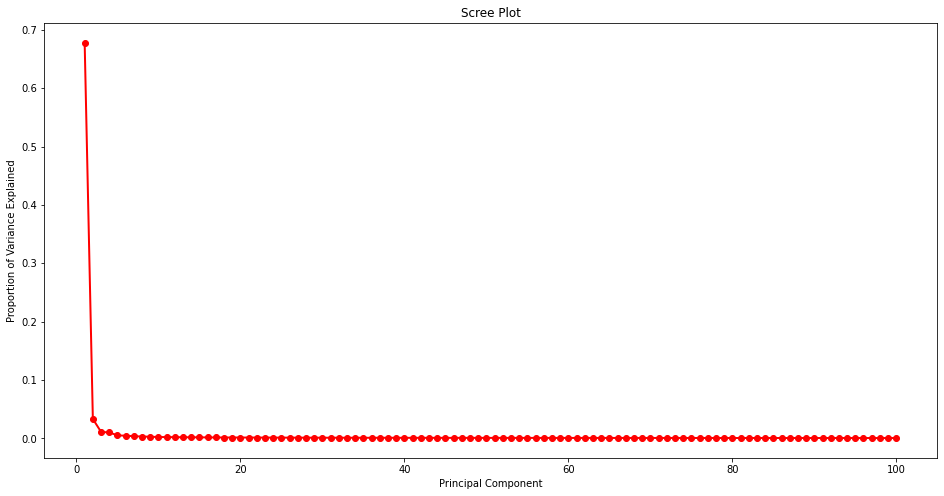

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_sm_scale)
print(f'Sum of Explained Variance: {pca.explained_variance_ratio_.sum()}')

plt.figure(figsize=(16,8))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [38]:
cross_validate(lrc, X_train_pca, y_train_sm, scoring=scoring, cv=3)

{'fit_time': array([0.22375846, 0.18286681, 0.23268604]),
 'score_time': array([0.01096463, 0.01010656, 0.00919437]),
 'test_accuracy': array([0.90264287, 0.91642196, 0.91843651]),
 'test_f1': array([0.89983732, 0.91685393, 0.91856531]),
 'test_precision': array([0.92631579, 0.91234347, 0.91711712]),
 'test_recall': array([0.87483055, 0.92140921, 0.92001808])}


cross_validate(lrc, X_train_pca, y_train_sm, scoring=scoring, cv=3)

{'fit_time': array([0.22375846, 0.18286681, 0.23268604]),

 'score_time': array([0.01096463, 0.01010656, 0.00919437]),

 'test_accuracy': array([0.90264287, 0.91642196, 0.91843651]),

 'test_f1': array([0.89983732, 0.91685393, 0.91856531]),

 'test_precision': array([0.92631579, 0.91234347, 0.91711712]),
 
 'test_recall': array([0.87483055, 0.92140921, 0.92001808])}

In [40]:
cross_validate(rfc, X_train_pca, y_train_sm, scoring=scoring, cv=5)

{'fit_time': array([8.25760913, 8.04582143, 7.95467877, 8.40611982, 8.07780504]),
 'score_time': array([0.05607224, 0.0552609 , 0.05160379, 0.05511451, 0.0554378 ]),
 'test_accuracy': array([0.94766566, 0.98418675, 0.98230422, 0.9811747 , 0.97439759]),
 'test_f1': array([0.94563942, 0.98422239, 0.98225746, 0.98118886, 0.97428139]),
 'test_precision': array([0.98372661, 0.982009  , 0.98485995, 0.98045113, 0.9787234 ]),
 'test_recall': array([0.91039157, 0.98644578, 0.97966867, 0.98192771, 0.96987952])}

{'fit_time': array([8.25760913, 8.04582143, 7.95467877, 8.40611982, 8.07780504]),

 'score_time': array([0.05607224, 0.0552609 , 0.05160379, 0.05511451, 0.0554378 ]),

 'test_accuracy': array([0.94766566, 0.98418675, 0.98230422, 0.9811747 , 0.97439759]),

 'test_f1': array([0.94563942, 0.98422239, 0.98225746, 0.98118886, 0.97428139]),

 'test_precision': array([0.98372661, 0.982009  , 0.98485995, 0.98045113, 0.9787234 ]),
 
 'test_recall': array([0.91039157, 0.98644578, 0.97966867, 0.98192771, 0.96987952])}

# Models:

## Tuning Hyperparameters

#Ridge

In [41]:
# Let's use GridSearchCV to find the best parameters.
# Let's start with Ridge Regularization.
# We are trying to tune the C paramater which is the inverse of Lambda.

lrc = LogisticRegression(max_iter=10000)

lrc_grid={"C":np.logspace(-3,3,4), "penalty":["l2"]}# l1 lasso l2 ridge

lrc_cv=GridSearchCV(lrc,lrc_grid,cv=3)
lrc_cv.fit(X_train_pca,y_train_sm)

print("Tuned Hyperparameters: ", lrc_cv.best_params_)
print("Accuracy: ", lrc_cv.best_score_)

Tuned Hyperparameters:  {'C': 10.0, 'penalty': 'l2'}
Accuracy:  0.9116720600113238


In [ ]:
# Super solid. Let's use GridSearchCV to find the best parameters.
# Let's start with Ridge Regularization.
# We are trying to tune the C paramater which is the inverse of Lambda.

rfc_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rfc_cv=GridSearchCV(rfc,rfc_grid,cv=3,n_jobs=-1)
rfc_cv.fit(X_train_pca,y_train_sm)

print("Tuned Hyperparameters: ", rfc_cv.best_params_)
print("Accuracy: ", rfc_cv.best_score_)

The output from this GridSearch gave:

Tuned Hyperparameters: {'C': 1000.0, 'penalty': 'l2'} accuracy : 0.9733435263005127

In [34]:
# Let's see how using these parameters work on the scores.

lrc=LogisticRegression(max_iter=10000, C=1000.0, penalty='l2')
#cross_validate(lrc, X_train_sm_scale, y_train_sm, scoring=scoring, cv=5)

Here is the output with SMOTE undersampling, scaled to [0,1]
using Logistic Regression with C = 1000.0 an Ridge Regularization

{'fit_time': array([220.00465965, 196.47716212, 224.8870132 , 190.50011492, 217.27800798]),

 'score_time': array([0.07161069, 0.06909347, 0.07424736, 0.07489944, 0.07284021]),

 'test_accuracy': array([0.97628012, 0.98230422, 0.97929217, 0.97966867, 0.97590361]), 

 'test_f1': array([0.97643098, 0.98261191, 0.97971228, 0.9800738 , 0.97647059]), 

 'test_precision': array([0.97026022, 0.96581818, 0.96023138, 0.96092619, 0.95402299]), 
 
 'test_recall': array([0.98268072, 1. , 1. , 1. , 1. ])}

#Lasso

In [35]:
# Okay I would like to compare that to a tuned Lasso Regularization.
# Unfortunately, I can't get this to complete in a reasonable amount of time.

lrc = LogisticRegression(max_iter=10000)

grid={"C":np.logspace(-2,2,3), "penalty":["l1"], "solver":["saga"]}# l1 lasso l2 ridge

#lrc_cv=GridSearchCV(lrc,grid,cv=3)
#lrc_cv.fit(X_train_sm_scale,y_train_sm)

print("Tuned hyperparameters: ", lrc_cv.best_params_)
print("Accuracy: ", lrc_cv.best_score_)

NameError: ignored

In [37]:
lrc=LogisticRegression(max_iter=10000, penalty='l1', C=1000.0, solver='saga')
cross_validate(lrc, X_train_sm_scale, y_train_sm, scoring=scoring, cv=3)

KeyboardInterrupt: ignored

In [ ]:
#lrc_cv=GridSearchCV(lrc,grid,cv=3)
#lrc_cv.fit(X_train_sm_scale,y_train_sm)

print("Tuned hyperparameters: ", lrc_cv.best_params_)
print("Accuracy: ", lrc_cv.best_score_)

#Elastic Net

In [ ]:
# I'm wondering if I can get even better results with Elastic Net, 
# but I get an error that l1 ratio must be between 0 and 1 and got l1_ratio=None.
# I can't get this code to run in a reasonable runtime.
# With more time I would keep working on this to see if I can get tuned hyperparameters.

#from datetime import datetime
#start=datetime.now()

#lrc = LogisticRegression(max_iter=10000)

#grid={"penalty":["elasticnet"], "solver":["saga"], "l1_ratio":np.linspace(.25,.75,3)}

#lrc_cv=GridSearchCV(lrc,grid,cv=3)
#lrc_cv.fit(X_train_sm_scale,y_train_sm)

#print("Tuned hyperparameters : ", lrc_cv.best_params_)
#print("Accuracy: ", lrc_cv.best_score_)

#print(datetime.now()-start)

In [36]:
lrc=LogisticRegression(max_iter=10000, penalty='elasticnet', l1_ratio=.5)
cross_validate(lrc, X_train_sm_scale, y_train_sm, scoring=scoring, cv=3)

{'fit_time': array([0.67897534, 0.26756454, 0.53229237]),
 'score_time': array([0., 0., 0.]),
 'test_accuracy': array([nan, nan, nan]),
 'test_f1': array([nan, nan, nan]),
 'test_precision': array([nan, nan, nan]),
 'test_recall': array([nan, nan, nan])}



---



### Assumptions of Logistic Regression
1. Independent Observations

 - Images are not related

2. Little to no multicollinearity among independent variables

 - Although adjacent pixels might be correlated, this will not yield trends across columns for all of the data.

3. Linearity of independent variables and log odds

 - Something to look into.

4. Large sample size

 - This has been achieved with SMOTE.

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
lrc=LogisticRegression(max_iter=10000, C=1000.0, penalty='l2')

lrc.fit(X_train_sm_scale, y_train_sm)
predict_test = lrc.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,['No Volcano','Volcano'],False)

In [ ]:
# These numbers are not matching up with what I saw before.
# There are way too many false positives.
# Will need to check this confusion matrix against other models.

tp = 268
tn = 751
fp = 909
fn = 19

def acc_rec_prec(tp,tn,fp,fn):
  accuracy = round(((tp+tn)/(tp+tn+fp+fn))*100,2)
  recall = round((tp/(tp+fn))*100, 2)
  precision = round((tp/(tp+fp))*100, 2)
  print(f'accuracy: {accuracy}%')
  print(f'recall: {recall}%')
  print(f'precision: {precision}%')

acc_rec_prec(tp,tn,fp,fn)

#Conclusions

##EDA:
For Exploratory Data Analysis, I had to fix the dataframes so that all of the pictures showed up and the image dataframes matched up with the labels. I found that there was class imbalance in the Volcanos? column that I was trying to predict. I created three different dataframes, one with the imbalanced, one with random undersampling, and one with SMOTE oversampling to compare in the different models.

##Model Performance:
I found it counterintuitive that the Logistic Regression was more successful than Random Forest Classifier. I initially spent a lot of time trying to tune the Random Forest Classifier before even trying the Logistic Regression Classifier. This is a reminder not to just try my favorite model, or the one I'm most interested in practicing. I then tried to use GridSearchCV to find the best hyperparameters. The runtime on these was costly, which led to me not optimizing across all of the parameters. Still, I achieved nearly 100% recall and over 95% Accuracy, Precision, and F1.

##Next Steps:
I would continue to try out different solvers and regularization algorithms to see if I can improve performance even more.

##Takeaways:
I learned so much during this project. I learned a lot about class imbalance, including different sampling techniques, but also the problem of using accuracy as your only score for model performance. I was forced to go back to learning about different regularization techniques and their parameters. I started using cross_validate instead of cross_val_scores because of the problem of accuracy score. I started playing with GridSearchCV and will need to keep playing with it to find a way to reduce runtime to get the most out of it.